In [16]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from fastai import layers
from fastai.basics import RandomSplitter
from fastai.data.core import DataLoaders
from fastai.learner import Learner
from fastai.optimizer import Adam, SGD
from fastai.torch_core import tensor
from fastai.vision.all import accuracy
from time import time
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
train_df = pd.read_csv("../input/digit-recognizer/train.csv")

X = train_df.loc[:, train_df.columns != "label"].values
y = train_df.label.values

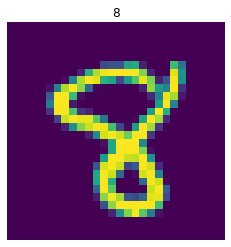

In [18]:
i = random.randint(0, len(X))
plt.imshow(X[i].reshape(28,28))
plt.axis("off")
plt.title(str(y[i]))
plt.savefig('graph.png')
plt.show()

In [19]:
class CustomTensorDataset(Dataset):
    def __init__(self, data, transform, validation_set=False):
        self.data = data.reset_index(drop=True)
        self.transform = transform
        self.validation_set = validation_set

    def __getitem__(self, index):
        if self.validation_set:
            x = self.data.iloc[index, :].values.reshape(1, 28, 28)
            x = self.transform(tensor(x) / 255)
            x = tensor(x)
            y = 0
        else:
            x = self.data.iloc[index, 1:].values.reshape(1, 28, 28)
            x = self.transform(tensor(x) / 255)
            y = self.data.iloc[index, 0]

        return x.to(device), tensor(y).to(device)

    def __len__(self):
        return self.data.shape[0]

In [20]:
ADD_TRANSFORMATIONS = True

data_transform = transforms.Compose([])
if ADD_TRANSFORMATIONS:
    data_transform = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.RandomResizedCrop(40, scale=(0.8, 1.0)),
            transforms.RandomRotation(degrees=(0, 10)),
#             transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
#             transforms.ColorJitter(brightness=0.2, contrast=0.2),
#             transforms.ToTensor(),
#             transforms.Normalize((0.1307,), (0.3081,)),
        ]
    )

In [21]:
batch_size = 100

train_idx, valid_idx = RandomSplitter(valid_pct=0.1, seed=42)(train_df)
train_tf = CustomTensorDataset(train_df.iloc[train_idx, :], data_transform)
test_tf = CustomTensorDataset(train_df.iloc[valid_idx, :], data_transform)

train_loader = DataLoader(train_tf, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_tf, batch_size=batch_size, shuffle=False)

dls = DataLoaders(train_loader, test_loader)

In [22]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = layers.ConvLayer(1, 32, ks=3)
        self.conv2 = layers.ConvLayer(32, 64, ks=3)
        self.conv3 = layers.ConvLayer(64, 128, ks=3)
        self.conv4 = layers.ConvLayer(128, 256, ks=3)
        self.conv5 = layers.ConvLayer(256, 512, ks=3)
        self.adapt1 = nn.AdaptiveAvgPool2d(1)
        self.flatten = layers.Flatten()
        self.fc1 = nn.Linear(512, 256)
        self.batch1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = F.max_pool2d(out, 3)

        out = self.conv3(out)
        out = self.conv4(out)
        out = F.max_pool2d(out, 3)

        out = self.conv5(out)
        out = self.adapt1(out)

        out = self.flatten(out)

        out = self.fc1(out)
        out = self.batch1(out)
        out = F.relu(out)
        out = self.fc2(out)

        return out

In [23]:
learning_rate = 0.01
lr_max = 0.1
weight_decay = 0.01
epochs = 25
use_sgd = False

model = Model().to(device)
learn = Learner(
    dls,
    model,
    metrics=accuracy,
    opt_func=SGD if use_sgd else Adam,
    loss_func=nn.CrossEntropyLoss(),
    lr=learning_rate,
)

In [24]:
learn.fit_one_cycle(n_epoch=epochs, lr_max=lr_max, wd=weight_decay)

epoch,train_loss,valid_loss,accuracy,time
0,0.120831,0.135031,0.957619,01:02
1,0.110040,0.219034,0.936667,01:03
2,0.114844,0.256779,0.938333,01:03
3,0.107679,0.129471,0.957143,01:01
4,0.096106,0.084629,0.973333,01:01
5,0.103422,0.162904,0.957381,01:01
6,0.082157,0.108320,0.968571,01:01
7,0.088087,0.147839,0.959286,01:02
8,0.083596,0.165270,0.953333,01:01
9,0.082169,0.103634,0.970000,01:03


In [25]:
predict_df = pd.read_csv("../input/digit-recognizer/test.csv")

predict_transform = transforms.Compose([])
if ADD_TRANSFORMATIONS:
    predict_transform = transforms.Compose([transforms.Resize(40)])

predict_dataset = CustomTensorDataset(predict_df, predict_transform, validation_set=True)
predict_loader = DataLoader(predict_dataset, batch_size=128)

In [26]:
predictions, _ = learn.get_preds(dl=predict_loader)
sub = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
sub["Label"] = np.argmax(predictions, axis=1)
sub.to_csv("submission.csv", index=False)
print(sub)

       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      0
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]
